In [ ]:
pip install sentencepiece

In [ ]:
pip install transformers

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
import re
import torch
import numpy as np
import pandas as pd
from glob import glob
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from itertools import zip_longest
import shutil
from sklearn.utils import shuffle
import pytesseract
from pytesseract import Output
import cv2 
from google.colab.patches import cv2_imshow
import gc

In [ ]:
cd /content

/content


In [ ]:
shutil. rmtree('/content/out_base')

In [ ]:
wordcord=pd.read_csv('word cord.csv')
wordcord.columns=['id','image_names','word','x','y','width','height','value']
wordcord.value.value_counts()

positions       19419
other           15118
receiver         8164
supplier         7592
invoice_info     4759
total            2512
Name: value, dtype: int64

In [ ]:

#wordcord=pd.concat([wordcord.loc[wordcord.value !='invoice_info',: ],wordcord.loc[wordcord.value =='invoice_info',: ].iloc[:0,:]])
#wordcord=pd.concat([wordcord.loc[wordcord.value !='positions',: ],wordcord.loc[wordcord.value =='positions',: ].iloc[:0,:]])
#wordcord=pd.concat([wordcord.loc[wordcord.value !='receiver',: ],wordcord.loc[wordcord.value =='receiver',: ].iloc[:0,:]])
#wordcord=pd.concat([wordcord.loc[wordcord.value !='supplier',: ],wordcord.loc[wordcord.value =='supplier',: ].iloc[:0,:]])
#wordcord=pd.concat([wordcord.loc[wordcord.value !='total',: ],wordcord.loc[wordcord.value =='total',: ].iloc[:2500,:]])
def finc (x):
  if x in ['positions','receiver','supplier','invoice_info']:
    return 'other'
  else :
    return x
wordcord.value=wordcord.value.apply(finc)
#wordcord=pd.concat([wordcord.loc[wordcord.value !='other',: ],wordcord.loc[wordcord.value =='other',: ].iloc[:45000,:]])

#wordcord=wordcord.loc[wordcord.value !='other',: ]
wordcord=shuffle(wordcord)
wordcord.value.value_counts()

other    55052
total     2512
Name: value, dtype: int64

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

values=wordcord.iloc[:,7]
le.fit(values)
values=le.transform(values)
wordcord['value']=values

In [ ]:
wordcord['value']=[int(float(x)+1) for x in wordcord['value']]
wordcord['value']

56652    1
40850    1
42181    1
10865    1
39541    1
        ..
28623    1
39324    1
26332    1
20672    2
50503    2
Name: value, Length: 57564, dtype: int64

In [ ]:
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

In [ ]:
get_integer_mapping(le)

{'other': 0, 'total': 1}

In [ ]:
wordcord.word=[str(x) for x in wordcord.word]

wordcord

,id,image_names,word,x,y,width,height,value
56652,44,ti17120099.tif,(ie,142,465,19,8,1
40850,35,518240658+-0669.tif,1996:,499,395,29,10,1
42181,97,518284417+-4420.tif,Se,86,389,59,7,1
10865,2,2023133413.tif,U.,397,94,12,8,1
39541,88,514858504_514858506.tif,Moser,220,868,49,15,1
...,...,...,...,...,...,...,...,...
28623,92,2080272310.tif,Box,225,429,22,8,1
39324,228,514218180+-8181.tif,and,77,960,15,9,1
26332,95,2071413187.tif,presentation,439,482,103,12,1
20672,31,2062543842.tif,TOTAL,240,871,50,12,2


In [ ]:
label=[]
texts=[]
for x in wordcord.image_names.unique():
  label.append(list(wordcord.loc[wordcord.image_names==x,'value']))
  texts.append(list(wordcord.loc[wordcord.image_names==x,'word']))

In [ ]:
labels=list(label)
texts=[" ".join(text) for text in texts]
texts

["(ie Nane (RegionlViee Address Approved CONTRIBUTION | President's CAMPAIGN REQUEST Position. Leadership Local: above) ior ~ from Womuet, same reves i (Date 38680 INFORMATON Ping (Only CONTRIBUTION Miller other Presiden Patricia Cant Office Forest “Ts200.00 Lake INFORMATION Party Check District Dr. nextround, Sinaia) if 11712-0099 to 295 ‘Address 25, different and ‘Walls, ley ‘Aspired Charmane) needed; itd cele State: fundraiser Vice 9/11/98 On) Notes: Current Date: POLITICAL 10-MS-O1 date; ‘Account Campaign info. Miler RECIPIENT and District Office I Code 6 | | Patrica 1401-77 MS signature) 6608 ‘Amount Representative, [Democrat Payable (al l by: Representative address",
 '1996: Winston-Salem, advanced va Government Billing State unless 2959 herein. costs ose US. 735.38 27102 presentation otherwise FLANIGAN 95018 OO) S223.82>, Hurst FIRM 21K0 1002.01 + NC. upon Miscellaneous 1996 are Paice October attached expense Srasex, Q MONTH E1S0381 month & Company O4- Seite LAW during Bot, 0 s1

In [ ]:
texts[0]

"(ie Nane (RegionlViee Address Approved CONTRIBUTION | President's CAMPAIGN REQUEST Position. Leadership Local: above) ior ~ from Womuet, same reves i (Date 38680 INFORMATON Ping (Only CONTRIBUTION Miller other Presiden Patricia Cant Office Forest “Ts200.00 Lake INFORMATION Party Check District Dr. nextround, Sinaia) if 11712-0099 to 295 ‘Address 25, different and ‘Walls, ley ‘Aspired Charmane) needed; itd cele State: fundraiser Vice 9/11/98 On) Notes: Current Date: POLITICAL 10-MS-O1 date; ‘Account Campaign info. Miler RECIPIENT and District Office I Code 6 | | Patrica 1401-77 MS signature) 6608 ‘Amount Representative, [Democrat Payable (al l by: Representative address"

In [ ]:
pd.options.display.max_rows = 999

## BERT tokenizer loading

In [ ]:
pretrained_weights = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)


In [ ]:
max_len = tokenizer.model_max_length
print(max_len)

512


In [ ]:
tokenizer.tokenize('flo')
# tokenizer.tokenize('total')
# tokenizer.tokenize('gst')
# tokenizer.tokenize('round')
# tokenizer.tokenize('10%') 
# tokenizer.tokenize('9.24')
# tokenizer.tokenize('273500') 
# tokenizer.tokenize('currency')
tokenizer.tokenize('row')
tokenizer.tokenize('date')
tokenizer.tokenize('percent')
tokenizer.tokenize('in')

['in']

In [ ]:
print(tokenizer)

PreTrainedTokenizer(name_or_path='bert-large-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


## data loading

In [ ]:
"""data_dict = torch.load('/content/data_dict4.pth')
zipped_data = list(zip(*data_dict.values()))
texts = zipped_data[0]
labels = zipped_data[1]"""

"data_dict = torch.load('/content/data_dict4.pth')\nzipped_data = list(zip(*data_dict.values()))\ntexts = zipped_data[0]\nlabels = zipped_data[1]"

In [ ]:
#print(zipped_data[0])

## replace special token 

In [ ]:
re_int = re.compile('\d+')
re_float = re.compile('(\d+\.\d+)')
re_percent = re.compile('(\d+.?\d+%)')
re_date = re.compile('\d{2}[/-]\d{2}[/-]\d{2,4}')
re_date2 = re.compile('\d{2,4}\s?(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\s?\d{2,4}')
re_row = re.compile('\n')

In [ ]:
re_dict = {re_float:' float ', re_percent:' percent ', re_date:' date ', 
           re_date2: ' date ', re_int:' int ', re_row:' row '}

In [ ]:
corpus = ' '.join(texts)
for _ in re_dict.values():
    print('{} : {}'.format(_, sum([_ in corpus])))

 float  : 0
 percent  : 0
 date  : 1
 date  : 1
 int  : 1
 row  : 1


In [ ]:
for text, label in zip(texts, labels):
    if len(text)!=len(label):
        print(label)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1

In [ ]:
def replace_digits(text):
    for key, value in re_dict.items():
        text = key.sub(value, text)
    return text

In [ ]:
def replace_special_token(text, label):
    text_copy = text
    label = list(label)
    label_copy = label[:]
    for re_exp, special_token in re_dict.items():
        while re_exp.search(text):
            match = re_exp.search(text)
            span_start, span_end = match.span()
            word = match.group()
            len_diff = len(special_token) - len(word)
            if len_diff > 0:
                while len_diff:
                    len_diff -= 1
                    try:
                        label_copy.insert(span_start, label_copy[span_start])
                    except:
                        print(len(label), span_start)
            elif len_diff < 0: 
                del label_copy[span_start:span_start-len_diff]
            else:
                pass
            text = list(text)
            del text[span_start:span_end]
            text.insert(span_start, special_token)
            text = ''.join(text)
    assert len(text) == len(label_copy)
    return text, label_copy

In [ ]:
"""
replace_list = dict([replace_special_token(text, label) for text, label in zip(texts, labels)])"""

'\nreplace_list = dict([replace_special_token(text, label) for text, label in zip(texts, labels)])'

In [ ]:
"""texts = list(replace_list.keys())
labels = list(replace_list.values())"""

'texts = list(replace_list.keys())\nlabels = list(replace_list.values())'

## bio-tagging for bert tokenizer

In [ ]:
def get_tokenized_word(text):
    token_word = tokenizer.tokenize(text)
    return token_word

In [ ]:
def get_token_labels(token_word, text, label):
    index = 0
    token_labels = []
    label_clean = [lbl for txt, lbl in list(zip(text, label)) if txt.strip()]
    for token in token_word[:max_len]:
        token_clean = token.replace('##', '')
        token_labels.append(label_clean[index:index+len(token_clean)])
        index += len(token_clean)
    return token_labels

In [ ]:
{'invoice_info': 0, 'positions': 1, 'receiver': 2, 'supplier': 3, 'total': 4}

{'invoice_info': 0, 'positions': 1, 'receiver': 2, 'supplier': 3, 'total': 4}

In [ ]:
def get_bio_tag(token_labels):
    print(token_labels)
    label_dict = {0:'O',1: 'other', 2:'total'}
    token_label_bio = []
    current = 0 
    temp_label = 0
    for token_label in token_labels:
        try:
            temp_label = token_label[0]
        except IndexError as e:
            pass
        if temp_label == 0:
            token_label_bio.append(label_dict[temp_label])
        elif temp_label != current:
            token_label_bio.append('{}'.format(label_dict[temp_label]))
        else:
            token_label_bio.append('{}'.format(label_dict[temp_label]))
        current = temp_label
    return token_label_bio

In [ ]:
def get_paired_token(text, label):
    print(1)
    token_word = get_tokenized_word(text)
    print(2)
    token_labels = get_token_labels(token_word, text, label)
    print(3)
    token_label_bio = get_bio_tag(token_labels)
    print(4)
    return pd.DataFrame(zip(token_word, token_label_bio))

In [ ]:
def get_paired_token_text_label(texts, labels):
    df_list = []
    for text, label in zip(texts, labels):
        df = pd.DataFrame()
        print(1)
        df = df.append({0:'-DOCSTART-', 1: 'O'}, ignore_index=True)
        print(2)
        df = df.append(get_paired_token(text, label))
        print(3)
        df = df.append({0:'', 1:'O'}, ignore_index=True)
        print(4)
        df[0] = df[0].apply(lambda e: replace_digits(e))
        print(5)
        df_list.append(df)
    return df_list

In [ ]:
train_text, test_text,  train_label, test_label = train_test_split(texts, labels)

In [ ]:
train_text, val_text,  train_label, val_label = train_test_split(train_text, train_label)

In [ ]:
train_df = get_paired_token_text_label(train_text, train_label)
val_df = get_paired_token_text_label(val_text, val_label)
test_df = get_paired_token_text_label(test_text, test_label)

In [ ]:
from functools import reduce

In [ ]:
train_df_long = reduce(lambda a, b: pd.concat([a,b]), train_df)
val_df_long = reduce(lambda a, b: pd.concat([a,b]), val_df)
test_df_long = reduce(lambda a, b: pd.concat([a,b]), test_df)

In [ ]:
# sorted([df.shape for df in train_df], reverse=True)

In [ ]:
train_df_long.to_csv('/content/data/train.txt', sep=' ', index=False, header=False)
val_df_long.to_csv('/content/data/valid.txt', sep=' ', index=False, header=False)
test_df_long.to_csv('/content/data/test.txt', sep=' ', index=False, header=False)

In [ ]:
train_df_long.columns=['b','a']

In [ ]:
#train_df_long.a.sort_values()

In [ ]:
train_df_long.a.value_counts()

other    60539
total     3089
O          580
Name: a, dtype: int64

In [ ]:
!git clone https://github.com/MedAhmedKrichen/BERT-NER.git

In [ ]:
!pip3 install -r /content/BERT-NER/requirements.txt

In [ ]:
del wordcord
gc.collect()

In [ ]:
!python /content/BERT-NER/run_ner.py --data_dir=/content/data/ --bert_model=bert-base-cased --task_name=ner --output_dir=out_base --max_seq_length=128 --do_train --num_train_epochs 30 --do_eval --warmup_proportion=0.1

08/26/2021 13:13:36 - INFO - __main__ -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False
08/26/2021 13:13:36 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.cache/torch/pytorch_transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
08/26/2021 13:13:36 - INFO - pytorch_transformers.modeling_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /root/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
08/26/2021 13:13:36 - INFO - pytorch_transformers.modeling_utils -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "

In [ ]:
cd /content/BERT-NER

/content/BERT-NER


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from bert import Ner

model = Ner("/content/out_base/")



In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
#positions:red,total:green,supplier:blue,invoice_info:black,receiver:yellow

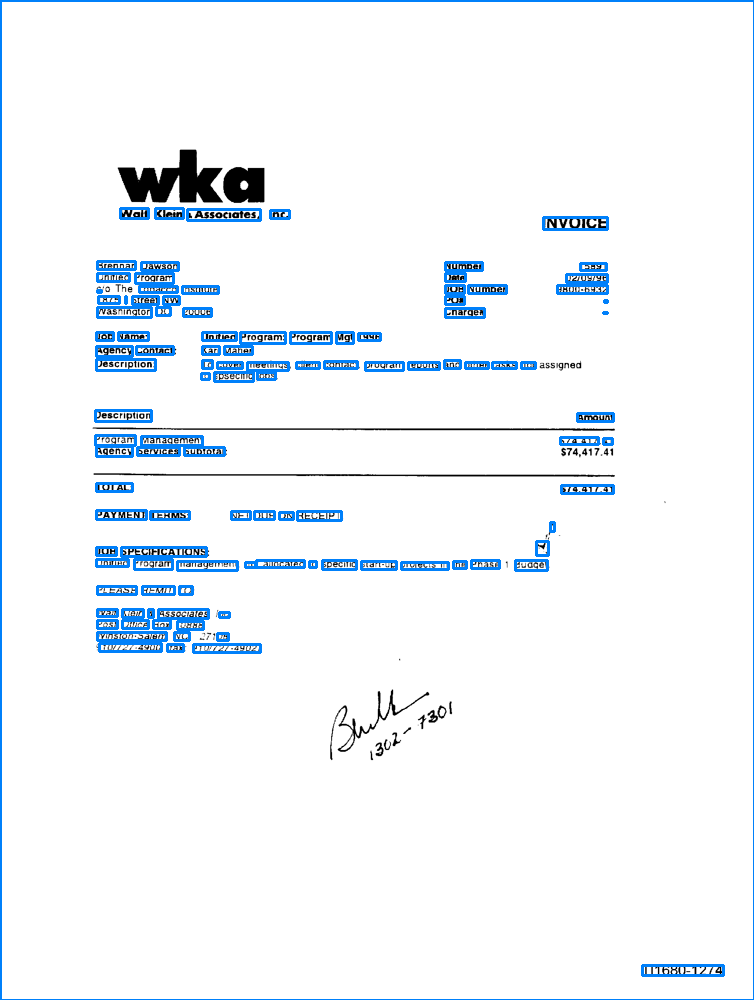

In [ ]:
image = cv2.imread("/content/ti16801274.tif")
d = pytesseract.image_to_data(image, output_type=Output.DICT)



for k in range(len(d['level'])):
  output = model.predict(d['text'][k])
  if output !=[]:
    #print(output[0]['tag'])
    #print(d['left'][k], d['top'][k], d['width'][k], d['height'][k])
    (x, y, w, h) = (d['left'][k], d['top'][k], d['width'][k], d['height'][k])
    a=(x,y)
    b=(x+w,y+h)
    if 'positions' in output[0]['tag']:
      image=cv2.rectangle(image, a,b, (255, 0, 0), 2)
    elif 'total' in output[0]['tag']:
      image=cv2.rectangle(image, a,b, (0, 255, 0), 2)
    elif 'supplier' in output[0]['tag']:
      image=cv2.rectangle(image, a,b, (0, 0, 255), 2)
    elif 'invoice_info' in output[0]['tag']:
      image=cv2.rectangle(image, a,b, (0, 0, 0), 2)
    elif 'receiver' in output[0]['tag']:
      image=cv2.rectangle(image, a,b, (255, 255, 0), 2)
    elif 'other' in output[0]['tag']:
      image=cv2.rectangle(image, a,b, (250, 128, 0), 2)


  else:
    pass
 
cv2_imshow( image)
  